In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [99]:
Measurement.__table__.columns.keys()
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

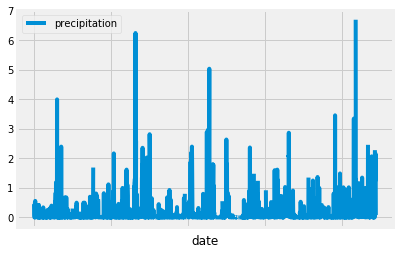

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1).all()

for r in last_date:
    date = r.date
date
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2016-08-23').all()

dates=[]
precip=[]

for row in query:
    dates.append(row.date)
    precip.append(row.prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(
    {"date":dates, 
    "precipitation":precip}
)
query_df.head()
# Sort the dataframe by date
query_sort = query_df.sort_values("date", ascending=False)
query_sort = query_sort.set_index("date")
# Use Pandas Plotting with Matplotlib to plot the data
query_sort.plot()

![precipitation](Images/precipitation.png)

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_sort.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [56]:
# Design a query to show how many stations are available in this dataset?
stations_query = pd.read_sql_query(session.query(func.count(Station.station)).statement, engine)

,count_1
0,9


In [61]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = pd.read_sql_query(
    session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).
    order_by(func.count(Measurement.station).desc()).statement, engine)
station_activity

,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [62]:
#the station with the most measurements
station_activity.head(1)

,station,count_1
0,USC00519281,2772


In [68]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station_df = pd.read_sql_query(
    session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).
    group_by(Measurement.station).filter(Measurement.station == "USC00519281").statement, engine)
top_station_df.head()

,station,min_1,max_1,avg_1
0,USC00519281,54.0,85.0,71.663781


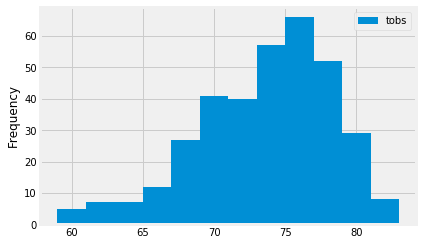

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_year_df = pd.read_sql_query(
    session.query(Measurement.date, Measurement.tobs).
    filter(Measurement.station == "USC00519281", Measurement.date>'2016-08-23').statement, engine)
top_station_year_df = top_station_year_df.set_index("date")
top_station_year_df.plot(kind='hist', bins=12)

![precipitation](Images/station-histogram.png)

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-29', '2017-06-01'))

[(71.0, 76.86363636363636, 81.0)]


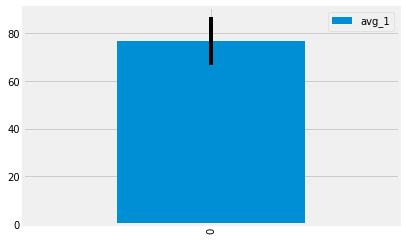

In [89]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.read_sql_query(session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= '2017-05-29').filter(Measurement.date <= '2017-06-01').statement, engine)
trip_df.plot(y="avg_1", kind='bar', yerr=(trip_df["max_1"]-trip_df["min_1"]))

In [106]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rainfall_df = pd.read_sql_query(session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).
        join(Station, Station.station==Measurement.station).group_by(Measurement.station).
        filter(Measurement.date >= '2017-05-29').filter(Measurement.date <= '2017-06-01').order_by(func.sum(Measurement.prcp).desc()).
        statement, engine)

trip_rainfall_df

,station,sum_1,latitude,longitude,elevation
0,USC00519281,1.77,21.45167,-157.84889,32.9
1,USC00513117,0.35,21.42340,-157.80150,14.6
2,USC00519397,0.28,21.27160,-157.81680,3.0
3,USC00519523,0.11,21.33556,-157.71139,19.5
4,USC00514830,0.04,21.52130,-157.83740,7.0
5,USC00516128,0.01,21.33310,-157.80250,152.4


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
